# LibriSpeech model visualizations

In [2]:
# load data
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

with open("../results/LibriSpeech_results.json", "r") as f:
    results = json.load(f)

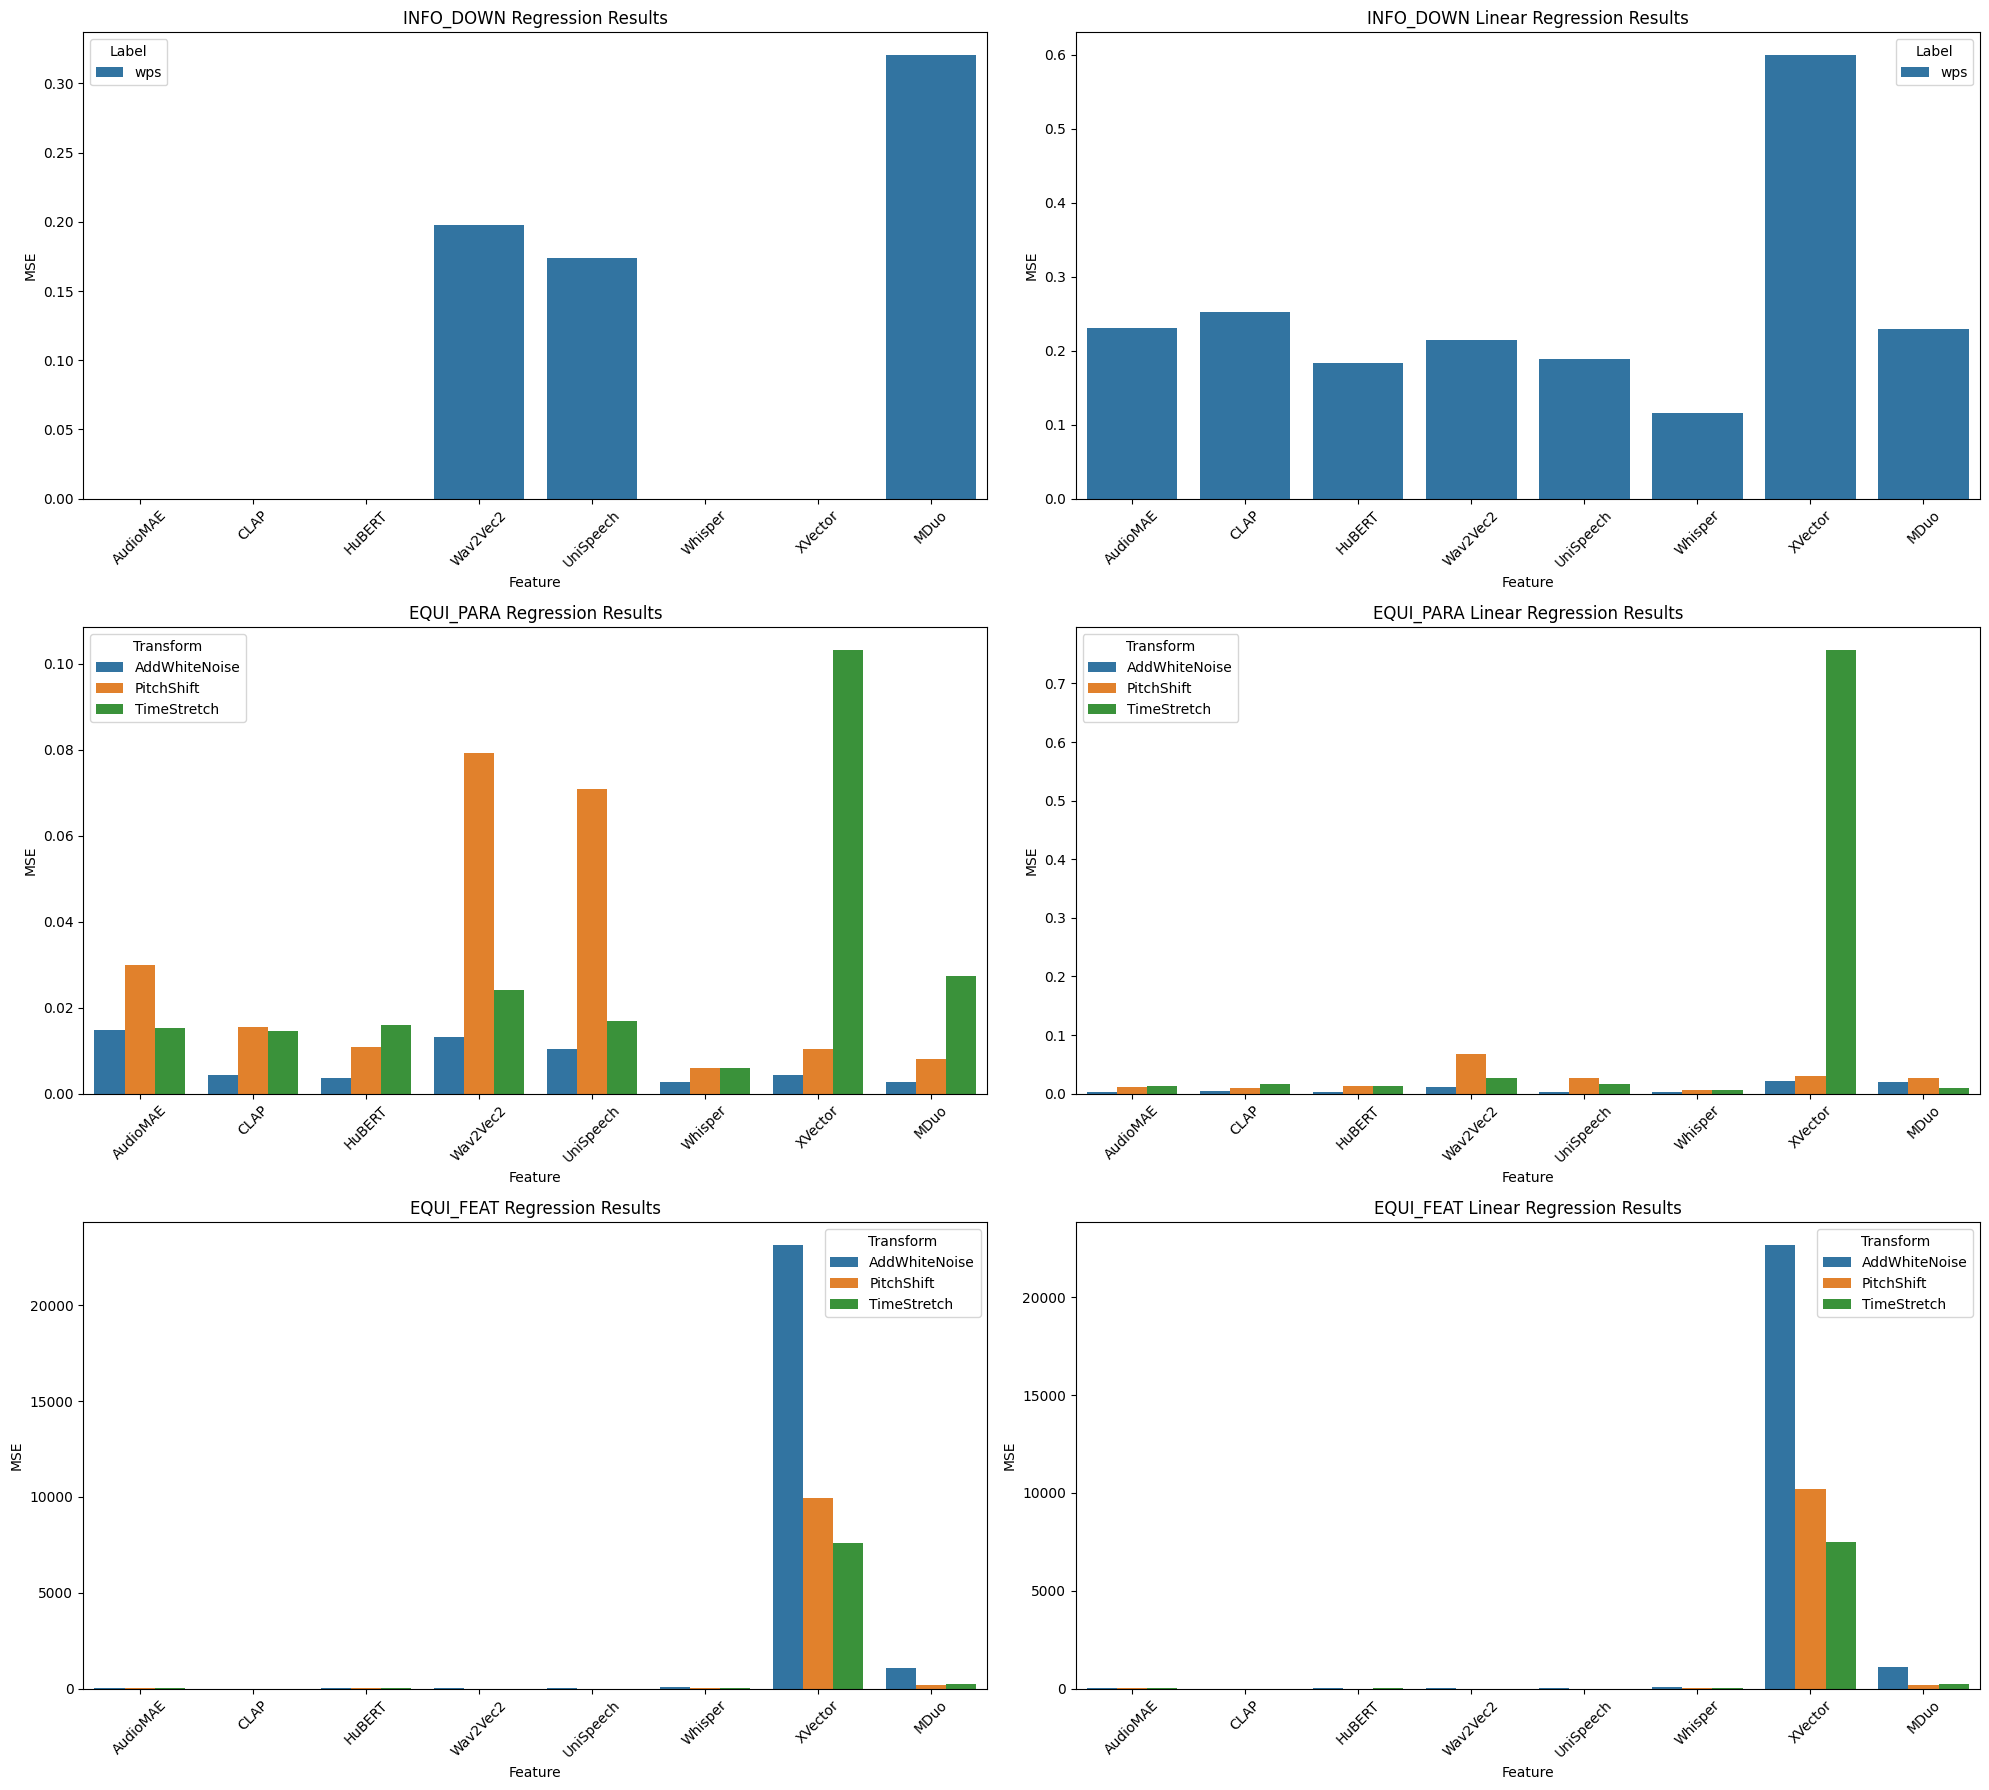

In [8]:
# Define consistent feature order
feature_order = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Constants for normalization (placeholders)
LABEL_SCALING = {
    "wps": 1,  # Placeholder value
}
TRANSFORM_SCALING = {
    "PitchShift": 1,
    "TimeStretch": 1,
    "AddWhiteNoise": 1,
}  # Placeholder values

# Create 2x3 subplot grid
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 18))

# 1. INFO_DOWN Plots
info_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "INFO_DOWN_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        label = next((l for l in ["wps"] if l in run_name), None)
        if feature and label:
            scaled_mse = metrics["MSE"] / LABEL_SCALING[label]
            if "linear" in run_name:
                info_data["linear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )
            else:
                info_data["nonlinear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )

df_info_nonlinear = pd.DataFrame(info_data["nonlinear"])
df_info_linear = pd.DataFrame(info_data["linear"])
sns.barplot(
    data=df_info_nonlinear,
    x="Feature",
    y="MSE",
    hue="Label",
    ax=ax1,
    order=feature_order,
)
sns.barplot(
    data=df_info_linear, x="Feature", y="MSE", hue="Label", ax=ax2, order=feature_order
)
ax1.set_title("INFO_DOWN Regression Results")
ax2.set_title("INFO_DOWN Linear Regression Results")
ax1.tick_params(axis="x", rotation=45)
ax2.tick_params(axis="x", rotation=45)

# 2. EQUI_PARA Plots
para_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "EQUI_PARA_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        transform = next(
            (
                t
                for t in ["PitchShift", "TimeStretch", "AddWhiteNoise"]
                if t in run_name
            ),
            None,
        )
        if feature and transform:
            if "linear" in run_name:
                para_data["linear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": metrics["mse"]}
                )
            else:
                para_data["nonlinear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": metrics["mse"]}
                )

df_para_nonlinear = pd.DataFrame(para_data["nonlinear"])
df_para_linear = pd.DataFrame(para_data["linear"])
sns.barplot(
    data=df_para_nonlinear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax3,
    order=feature_order,
)
sns.barplot(
    data=df_para_linear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax4,
    order=feature_order,
)
ax3.set_title("EQUI_PARA Regression Results")
ax4.set_title("EQUI_PARA Linear Regression Results")
ax3.tick_params(axis="x", rotation=45)
ax4.tick_params(axis="x", rotation=45)

# 3. EQUI_FEAT Plots
feat_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results.items():
    if "EQUI_FEAT_regression_" in run_name:
        feature = next((f for f in feature_order if f in run_name), None)
        transform = next(
            (
                t
                for t in ["PitchShift", "TimeStretch", "AddWhiteNoise"]
                if t in run_name
            ),
            None,
        )
        if feature and transform:
            scaled_mse = metrics["avg_l2_distance"]
            if "linear" in run_name:
                feat_data["linear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": scaled_mse}
                )
            else:
                feat_data["nonlinear"].append(
                    {"Feature": feature, "Transform": transform, "MSE": scaled_mse}
                )

df_feat_nonlinear = pd.DataFrame(feat_data["nonlinear"])
df_feat_linear = pd.DataFrame(feat_data["linear"])
sns.barplot(
    data=df_feat_nonlinear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax5,
    order=feature_order,
)
sns.barplot(
    data=df_feat_linear,
    x="Feature",
    y="MSE",
    hue="Transform",
    ax=ax6,
    order=feature_order,
)
ax5.set_title("EQUI_FEAT Regression Results")
ax6.set_title("EQUI_FEAT Linear Regression Results")
ax5.tick_params(axis="x", rotation=45)
ax6.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()